In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
% matplotlib inline

import sem
import story_generation
from event_schemas import LinearMLP, BasicRNN, LinearRNN, BoundedRNN
import hrr

Using TensorFlow backend.


### demo functions

In [2]:
# find closest vector to prediction in a pool of objects using euclidean distance
def eucl_match(prediction, objects):
    dists = list(map(lambda x : np.linalg.norm(prediction - x), objects))
    index = dists.index(min(dists)) 
    return objects[index]

In [3]:
# semantic error between prediction and actual components of scene
def semantic_error(constants, predicted_scene, semantic_truth):
    # decode fillers of predicted scene from roles
    decode_subj = hrr.decode(predicted_scene, constants['placeholders']['subject'])
    decode_subj_noun = hrr.decode(decode_subj, constants['placeholders']['noun'])
    decode_subj_property = hrr.decode(decode_subj, constants['placeholders']['property'])
    decode_verb = hrr.decode(predicted_scene, constants['placeholders']['verb'])
    decode_obj = hrr.decode(predicted_scene, constants['placeholders']['object'])
    decode_obj_noun = hrr.decode(decode_obj, constants['placeholders']['noun'])
    decode_obj_property = hrr.decode(decode_obj, constants['placeholders']['property'])
    
    # normalize pool of filler vectors
    normalized_nouns = list(map(lambda x: hrr.normalize(x), constants['nouns'].values())) + list(map(lambda x: hrr.normalize(x['vector']), actors))
    normalized_verbs = list(map(lambda x: hrr.normalize(x), constants['verbs'].values()))
    normalized_properties = list(map(lambda x: hrr.normalize(x), constants['properties'].values()))
    normalized_properties.append(hrr.normalize(constants['placeholders']['null_property']))
    
    # match each predicted filler to the closest generative filler 
    pred_subj_noun = eucl_match(hrr.normalize(decode_subj_noun), normalized_nouns)
    pred_subj_property = eucl_match(hrr.normalize(decode_subj_property), normalized_properties)
    pred_verb = eucl_match(hrr.normalize(decode_verb), normalized_verbs)
    pred_obj_noun = eucl_match(hrr.normalize(decode_obj_noun), normalized_nouns)
    pred_obj_property = eucl_match(hrr.normalize(decode_obj_property), normalized_properties)

    # semantic error is fraction of predicted fillers that are different from the true filler
    incorrect = 0
    
    subj_noun_error = np.linalg.norm(np.asarray(hrr.normalize(decode_subj_noun)) - np.asarray(hrr.normalize(semantic_truth['subject_noun'])))
    subj_prop_error = np.linalg.norm(np.asarray(hrr.normalize(decode_subj_property)) - np.asarray(hrr.normalize(semantic_truth['subject_property'])))
    verb_error = np.linalg.norm(np.asarray(hrr.normalize(decode_verb)) - np.asarray(hrr.normalize(semantic_truth['verb'])))
    obj_noun_error = np.linalg.norm(np.asarray(hrr.normalize(decode_obj_noun)) - np.asarray(hrr.normalize(semantic_truth['object_noun'])))
    obj_prop_error = np.linalg.norm(np.asarray(hrr.normalize(decode_obj_property)) - np.asarray(hrr.normalize(semantic_truth['object_property'])))
    return subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error

In [4]:
# artificially encode and decode scenes
# generates a set of fillers for each role
# given a role type, chooses a filler as a variable in the encoding
# get decoding accuracy from chosen filler
def demo_decoding_accuracy(trials, num_fillers, dim, orthogonal=False):
    correct_noun = 0.0; correct_verb = 0.0; correct_noun_noise = 0.0; correct_verb_noise = 0.0
    for t in range(trials):
        if orthogonal:
            noun = np.zeros(dim)
            noun[0] = 1
            prop = np.zeros(dim)
            prop[1] = 1
            verb = np.zeros(dim)
            verb[2] = 1
            subj = np.zeros(dim)
            subj[3] = 1
            obj = np.zeros(dim)
            obj[4] = 1
        else: 
            noun = hrr.embed_2d(dim, None)
            prop = hrr.embed_2d(dim, None)
            verb = hrr.embed_2d(dim, None)
            subj = hrr.embed_2d(dim, None)
            obj = hrr.embed_2d(dim, None)
        
        # embed fillers
        noun_fillers = []
        verb_fillers = []
        for i in range(num_fillers):
            noun_fillers.append(hrr.embed_2d(dim, None))
            verb_fillers.append(hrr.embed_2d(dim, None))
        sn = noun_fillers[0]
        sp = hrr.embed_2d(dim, None)
        v = verb_fillers[0]
        op = hrr.embed_2d(dim, None)
        on = hrr.embed_2d(dim, None)
        normalized_noun_fillers = list(map(lambda x: hrr.normalize(x), noun_fillers))
        normalized_verb_fillers = list(map(lambda x: hrr.normalize(x), verb_fillers))

        # construct scene by encoding
        subject_composite = hrr.encode(sn, noun) + hrr.encode(sp, prop)
        object_composite = hrr.encode(on, noun) + hrr.encode(op, prop)
        scene = hrr.encode(subj, subject_composite) + hrr.encode(verb, v) + hrr.encode(obj, object_composite)
        
        # reconstruct fillers by decoding with role
        noise = hrr.normalize(np.random.random(dim) * 2 - 1) * 1
        prediction_noun = hrr.normalize(hrr.decode(hrr.decode(scene, subj), noun))
        prediction_verb = hrr.normalize(hrr.decode(scene, verb))
        prediction_noun_noise = hrr.normalize(hrr.decode(hrr.decode(hrr.normalize(scene) + noise, subj), noun))
        prediction_verb_noise = hrr.normalize(hrr.decode(hrr.normalize(scene) + noise, verb))
        
        # evaluate prediction match against all fillers
        correct_noun += int(list(eucl_match(prediction_noun, normalized_noun_fillers)) == list(hrr.normalize(sn)))
        correct_noun_noise += int(list(eucl_match(prediction_noun_noise, normalized_noun_fillers)) == list(hrr.normalize(sn)))
        correct_verb += int(list(eucl_match(prediction_verb, normalized_verb_fillers)) == list(hrr.normalize(v)))
        correct_verb_noise += int(list(eucl_match(prediction_verb_noise, normalized_verb_fillers)) == list(hrr.normalize(v)))            
    return correct_noun/trials, correct_noun_noise/trials, correct_verb/trials, correct_verb_noise/trials

### noisy reconstruction tests

We want to check that a scene constructed through HRR encoding of roles and fillers can be decoded by returning the filler when provided a role. One filler from a pool is chosen to fill a role while the rest of the scene is kept constant, and the role is then used to decode the scene; the filler is decoded correctly if the closest filler in the pool to the decoded result is indeed the filler used to generate the scene. Across many trials with different random vector embeddings, we define decoding accuracy to be the fraction of trials where the filler is decoded correctly.

We use the scene structure:

$filler_{subject} \otimes [filler_{noun} \otimes noun \oplus filler_{property} \otimes property] \oplus filler_{verb} \otimes verb \oplus filler_{object} \otimes [filler_{noun} \otimes noun \oplus filler_{property} \otimes property]$

Variables that influence the decoding accuracy are the size of the filler pool, the role that we are filling (noun, verb, or property), the dimensionality of embeddings, the method of embedding role vectors, and the noise added to the scene between encoding and reconstruction.

##### accuracy decline with increased number of fillers (fixed dimensionality)

In [6]:
dim = 50
trials = 1000

res_noun = {}
res_noun_noise = {}
res_noun_orthogonal = {}
res_noun_noise_orthogonal = {}

res_verb = {}
res_verb_noise = {}
res_verb_orthogonal = {}
res_verb_noise_orthogonal = {}

for num in range(1, 21):
    a, b, c, d = demo_decoding_accuracy(trials, num, dim, orthogonal=False)   
    res_noun[num] = a
    res_noun_noise[num] = b
    res_verb[num] = c
    res_verb_noise[num] = d
        
for num in range(1, 21):
    a, b, c, d = demo_decoding_accuracy(trials, num, dim, orthogonal=True)   
    res_noun_orthogonal[num] = a
    res_noun_noise_orthogonal[num] = b
    res_verb_orthogonal[num] = c
    res_verb_noise_orthogonal[num] = d

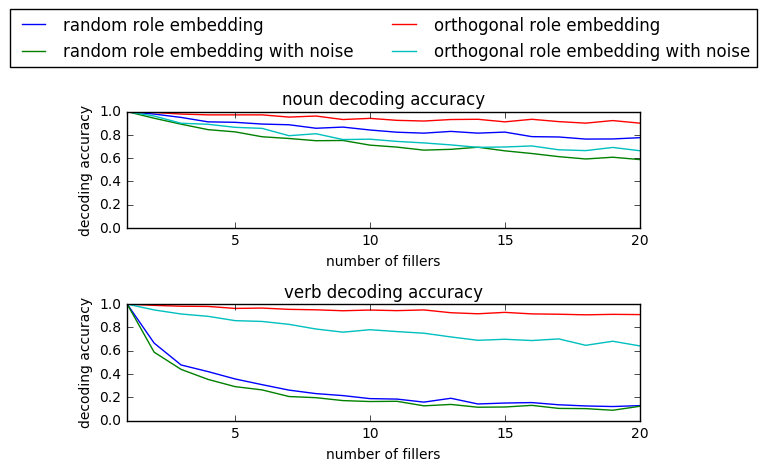

In [7]:
plt.subplot(2, 1, 1)
plt.plot(res_noun.keys(), res_noun.values(), label='random role embedding')
plt.plot(res_noun_noise.keys(), res_noun_noise.values(), label='random role embedding with noise')
plt.plot(res_noun_orthogonal.keys(), res_noun_orthogonal.values(), label='orthogonal role embedding')
plt.plot(res_noun_noise_orthogonal.keys(), res_noun_noise_orthogonal.values(), label='orthogonal role embedding with noise')
plt.xlim([1, 20])
plt.ylim([0, 1])
plt.xlabel("number of fillers")
plt.ylabel("decoding accuracy")
plt.title("noun decoding accuracy")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.95), ncol=2)
plt.subplot(2, 1, 2)
plt.plot(res_verb.keys(), res_verb.values(), label='random role embedding')
plt.plot(res_verb_noise.keys(), res_verb_noise.values(), label='random role embedding with noise')
plt.plot(res_verb_orthogonal.keys(), res_verb_orthogonal.values(), label='orthogonal role embedding')
plt.plot(res_verb_noise_orthogonal.keys(), res_verb_noise_orthogonal.values(), label='orthogonal role embedding with noise')
plt.xlim([1, 20])
plt.ylim([0, 1])
plt.xlabel("number of fillers")
plt.ylabel("decoding accuracy")
plt.title("verb decoding accuracy")
plt.tight_layout()
plt.show()

For noun decoding, using orthogonal role vectors linearly diminishes the  decrease in accuracy as a function of increased number of fillers, but for verb decoding the orthogonal role vectors drastically improves performance. A likely cause is that because the verb filler is directly decoded and the noun filler is obtained through 2 layers of decoding, decoding the verb filler is more sensitive to variability in embedding; for instance if the randomly embedded verb role and a different role are similar, the decoded verb filler may be confounded (for the noun, we decode first using the subject or object filler and then using the noun filler, which reduces this issue. The special orthogonal embedding of role vectors is biologically reasonable, as we have very clear distinctions between verbs, nouns, adjectives, etc. 

Introducing a constant amount of noise linearly magnifies the decrease in accuracy as a function of increased number of fillers.

##### accuracy increase with increased dimensionality (fixed number of fillers)

In [9]:
num = 50
max_dim = 155
trials = 1000

res_noun = []
res_noun_noise = []
res_noun_orthogonal = []
res_noun_noise_orthogonal = []

res_verb = []
res_verb_noise = []
res_verb_orthogonal = []
res_verb_noise_orthogonal = []

for dim in np.arange(5, max_dim, 5):
    a, b, c, d = demo_decoding_accuracy(trials, num, dim, orthogonal=False)   
    res_noun.append(a)
    res_noun_noise.append(b)
    res_verb.append(c)
    res_verb_noise.append(d)
    
for dim in np.arange(5, max_dim, 5):
    a, b, c, d = demo_decoding_accuracy(trials, num, dim, orthogonal=True)   
    res_noun_orthogonal.append(a)
    res_noun_noise_orthogonal.append(b)
    res_verb_orthogonal.append(c)
    res_verb_noise_orthogonal.append(d)

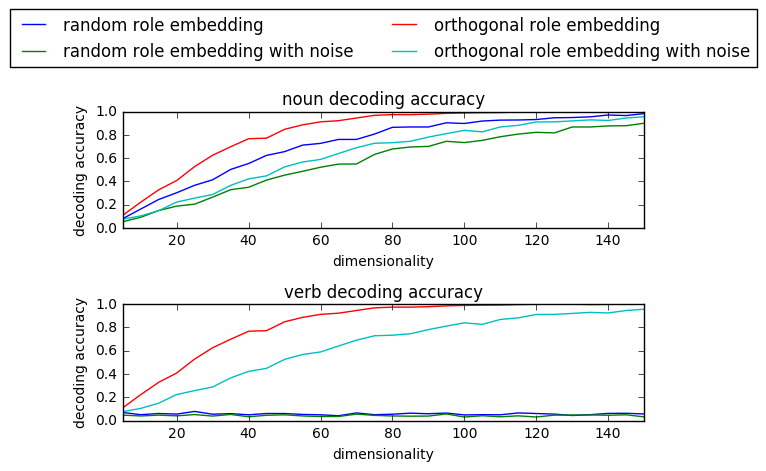

In [30]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(5, max_dim, 5), res_noun, label='random role embedding')
plt.plot(np.arange(5, max_dim, 5), res_noun_noise, label='random role embedding with noise')
plt.plot(np.arange(5, max_dim, 5), res_noun_orthogonal, label='orthogonal role embedding')
plt.plot(np.arange(5, max_dim, 5), res_noun_noise_orthogonal, label='orthogonal role embedding with noise')
plt.xlim([5, max_dim-5])
plt.xlabel("dimensionality")
plt.ylabel("decoding accuracy")
plt.title("noun decoding accuracy")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.95), ncol=2)
plt.subplot(2, 1, 2)
plt.plot(np.arange(5, max_dim, 5), res_verb, label='random role embedding')
plt.plot(np.arange(5, max_dim, 5), res_verb_noise, label='random role embedding with noise')
plt.plot(np.arange(5, max_dim, 5), res_noun_orthogonal, label='orthogonal role embedding')
plt.plot(np.arange(5, max_dim, 5), res_noun_noise_orthogonal, label='orthogonal role embedding with noise')
plt.xlim([5, max_dim-5])
plt.xlabel("dimensionality")
plt.ylabel("decoding accuracy")
plt.title("verb decoding accuracy")
plt.tight_layout()
plt.show()

Once again we see that orthogonal embedding of roles is crucial for the verb decoding accuracy. For all cases apart from the randomly embedded verb role, decoding accuracy increases with the dimensionality of the embedding.

##### required dimensionality to maintain accuracy with increased number of fillers (orthogonal embedding, noun role)

In [12]:
accuracy_threshold = 0.9
trials = 1000

max_dim = 305
nums=[]
matches = []
for num in np.arange(5, 205, 5):
    nums.append(num)
    base = 5
    # heuristic for improving run time
    if len(matches) > 1:
        base = max(base, matches[-1]-10)
    for dim in np.arange(base, max_dim, 5):
        a, b, c, d = demo_decoding_accuracy(trials, num, dim, orthogonal=True)   
        if a >= accuracy_threshold:
            matches.append(dim)
            break
    if len(nums) > len(matches):
        matches.append(0)

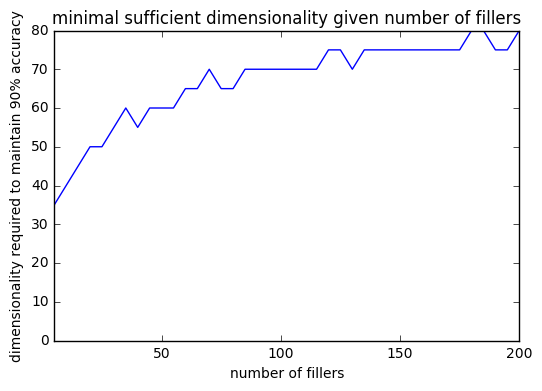

In [27]:
plt.plot(nums, matches)
plt.ylim(0, 80)
plt.xlim(5, 200)
plt.xlabel("number of fillers")
plt.ylabel("dimensionality required to maintain 90% accuracy")
plt.title("minimal sufficient dimensionality given number of fillers")

Accuracy increases with the dimensionality but decreases with the number of fillers, so we want to see the dimensionality required to keep a given level of accuracy for different numbers of fillers. 

### comparing different scene structures

Want to ensure that decoding is robust under compounded binding and compounded addition. In these tests we fix the dimension.

##### decoding accuracy with compounded addition

In [19]:
dim = 50
num_fillers = 10
var = []
res = []
for sum_length in range(1, 10):
    var.append(sum_length)
    correct = 0.0
    for i in range(1000):
        fillers = []
        for j in range(num_fillers):
            fillers.append(hrr.embed_2d(dim, None))
        normalized_fillers = list(map(lambda x: hrr.normalize(x), fillers))

        role = hrr.embed_2d(dim, None)
        scene = hrr.encode(role, fillers[0])
        for j in range(sum_length - 1):
            add = hrr.encode(hrr.embed_2d(dim, None), hrr.embed_2d(dim, None))
            scene += add
        pred = hrr.normalize(hrr.decode(scene, role))
        correct += int(list(eucl_match(pred, normalized_fillers)) == list(hrr.normalize(fillers[0])))
    res.append(correct/1000.0)

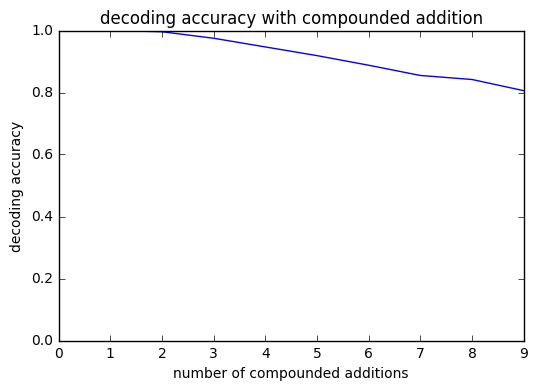

In [23]:
plt.plot(var, res)
plt.ylim(0, 1)
plt.xlim(0, 9)
plt.xlabel("number of compounded additions")
plt.ylabel("decoding accuracy")
plt.title("decoding accuracy with compounded addition")

##### decoding accuracy with compounded binding

In [21]:
# compositional limits
dim = 50
num_fillers = 10
var = []
res = []
for binding_depth in range(10):
    var.append(binding_depth)
    correct = 0.0
    for i in range(1000):
        fillers = []
        for j in range(num_fillers):
            fillers.append(hrr.embed_2d(dim, None))
        normalized_fillers = list(map(lambda x: hrr.normalize(x), fillers))

        roles = []
        scene = fillers[0]
        for j in range(binding_depth):
            current_role = hrr.embed_2d(dim, None)
            roles.append(current_role)
            scene = hrr.encode(scene, current_role)
        pred = scene
        for role in reversed(roles):
            pred = hrr.decode(pred, role)

        correct += int(list(eucl_match(pred, normalized_fillers)) == list(hrr.normalize(fillers[0])))
    res.append(correct/1000.0)

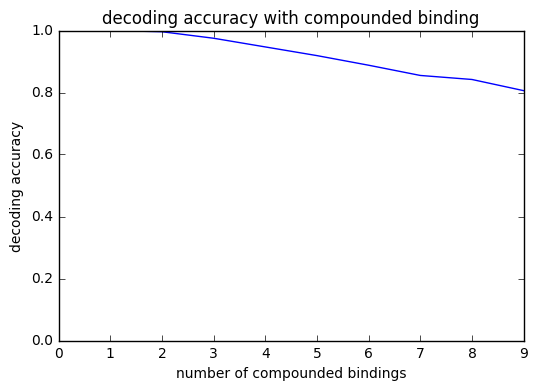

In [24]:
plt.plot(var, res)
plt.ylim(0, 1)
plt.xlim(0, 9)
plt.xlabel("number of compounded bindings")
plt.ylabel("decoding accuracy")
plt.title("decoding accuracy with compounded binding")